Instalamos las librerias necesarias

In [113]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import numpy as np
import random

Conectamos al drive

In [114]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos el dataframe escogiendo una muestra para no sobrecargar la RAM

In [115]:
df = pd.read_csv('drive/MyDrive/bases_de_datos/cleaned_cellphones.csv')
df.loc[:, 'sentiment'] = [0 if rank <= 3 else 1 for rank in df['overall']]
df = df[df['cleaned_reviewtext'] != ''].sample(2000).reset_index(drop=True)
df.head()

,cleaned_reviewtext,overall,sentiment
0,bought tmobile gs2 white one want clunky case ...,5,1
1,regularly use blueant headset thus compare new...,3,0
2,purchased advertised oem fact excellent produc...,5,1
3,real issue putting know condition burned three...,2,0
4,clip ok hold phone nice snug vertical position...,3,0


Separamos en entrenamiento y test

In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_reviewtext'],
    df['sentiment'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=df['sentiment']
)

Extracción de features

In [117]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=5, strip_accents='ascii')

TF-IDF scores del training set y test set

In [118]:
cv.fit(X_train.values.astype('U'))
print(list(cv.vocabulary_.items())[:20])
print(len(cv.vocabulary_))
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test) 

[('color', 274), ('clear', 263), ('would', 1759), ('like', 850), ('white', 1723), ('iphone', 781), ('could', 338), ('still', 1496), ('case', 230), ('phone', 1109), ('also', 60), ('plastic', 1126), ('around', 99), ('button', 206), ('extremely', 519), ('hard', 678), ('use', 1666), ('full', 611), ('force', 592), ('turn', 1632)]
1772


entrenamiento de regresión logística viendo las distintas precisiones para escoger el mejor parámetro


In [119]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))
    


Accuracy for C=0.01: 0.774
Accuracy for C=0.05: 0.774
Accuracy for C=0.25: 0.774
Accuracy for C=0.5: 0.782
Accuracy for C=1: 0.788
Accuracy for C=10: 0.806
Accuracy for C=100: 0.798
Accuracy for C=1000: 0.796
Accuracy for C=10000: 0.788


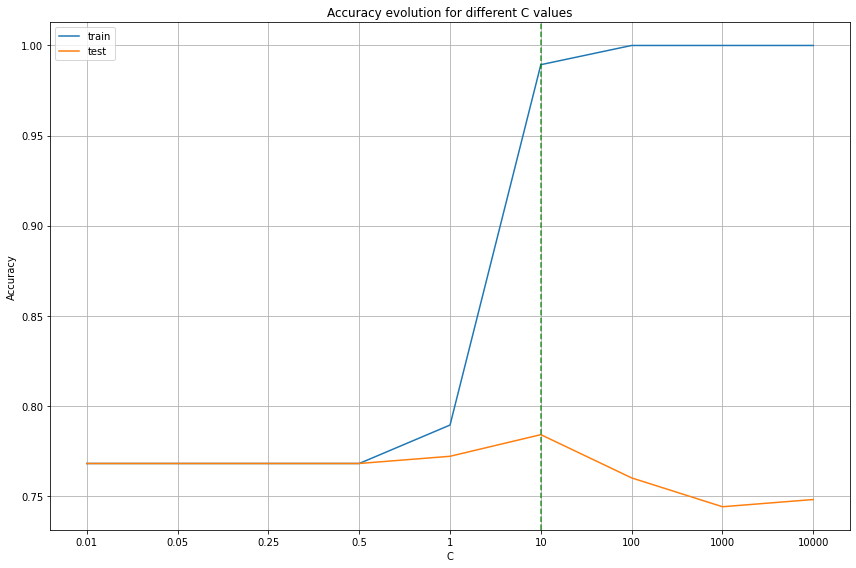

In [83]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Vemos que la mejor precisión se consigue para c=10 siendo superior al 80%

In [120]:
lr = LogisticRegression(C=10, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)
lr_train_predict = lr.predict(X_train_)
lr_test_predict = lr.predict(X_test_)
pickle.dump(lr, open('../content/lr.pkl', 'wb'))

In [121]:
def print_model_metrics(y_test, y_test_predict):
    print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_test_predict)))
    print('\nClassification report:\n{}'.format(classification_report(y_test, y_test_predict)))
    print('Accuracy score:{}'.format(accuracy_score(y_test, y_test_predict)))

In [122]:
print_model_metrics(y_test, lr_test_predict)

Confussion matrix:
[[ 34  79]
 [ 18 369]]

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.30      0.41       113
           1       0.82      0.95      0.88       387

    accuracy                           0.81       500
   macro avg       0.74      0.63      0.65       500
weighted avg       0.79      0.81      0.78       500

Accuracy score:0.806


Entrenamiento de Multinomial Naive Bayes

In [123]:
mnb = MultinomialNB()
mnb.fit(X_train_, y_train)
mnb_train_predict = mnb.predict(X_train_)
mnb_test_predict = mnb.predict(X_test_)
mnb_test_predict_accuracy = accuracy_score(y_test, mnb_test_predict)
mnb_test_predict_accuracy

0.776

In [124]:
pickle.dump(mnb, open('../content/mnb.pkl', 'wb'))

In [125]:
print_model_metrics(y_test, mnb_test_predict)

Confussion matrix:
[[  2 111]
 [  1 386]]

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.02      0.03       113
           1       0.78      1.00      0.87       387

    accuracy                           0.78       500
   macro avg       0.72      0.51      0.45       500
weighted avg       0.75      0.78      0.68       500

Accuracy score:0.776


Vemos que la precisión es similar pero el de regresión logística es algo superior, vamos a realizar varias predicciones, tomando entradas aleatorias de nuestra muestra a ver cual de ellos acierta más.

In [126]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index,2]))
    r = df.iloc[review_index,0]
    print('Prediction with lr: {}'.format(lr.predict(cv.transform([r]))))
    print('Prediction with mnb: {}'.format(mnb.predict(cv.transform([r]))))

In [127]:
for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 1218
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 212
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 49
Actual sentiment: 0
Prediction with lr: [0]
Prediction with mnb: [1]

Review no. 375
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 976
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 576
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 1044
Actual sentiment: 0
Prediction with lr: [0]
Prediction with mnb: [1]

Review no. 1457
Actual sentiment: 0
Prediction with lr: [0]
Prediction with mnb: [1]

Review no. 1769
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 750
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]


El modelo de regresión logística ha acertado en todas las predicciones, mientras que el modelo de Multinomial Naive Bayes ha fallado en las que debería de haber predecido un 0, por lo que el mejor modelo es el primero.